In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import requests
from datetime import datetime
# Load dataset and parse launch date
df = pd.read_csv("spacex_launches.csv", parse_dates=["date_utc"])

# Preview basic info
print(df.shape)
print(df.columns.tolist())
print(df.dtypes)
df.head()


(205, 43)
['static_fire_date_utc', 'static_fire_date_unix', 'net', 'window', 'rocket', 'success', 'failures', 'details', 'crew', 'ships', 'capsules', 'payloads', 'launchpad', 'flight_number', 'name', 'date_utc', 'date_unix', 'date_local', 'date_precision', 'upcoming', 'cores', 'auto_update', 'tbd', 'launch_library_id', 'id', 'fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships', 'links.patch.small', 'links.patch.large', 'links.reddit.campaign', 'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery', 'links.flickr.small', 'links.flickr.original', 'links.presskit', 'links.webcast', 'links.youtube_id', 'links.article', 'links.wikipedia', 'fairings']
static_fire_date_utc                      object
static_fire_date_unix                    float64
net                                         bool
window                                   float64
rocket                                    object
success                                   object
fail

,static_fire_date_utc,static_fire_date_unix,net,window,rocket,success,failures,details,crew,ships,...,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 33, 'altitude': None, 'reason': 'mer...",Engine failure at 33 seconds and loss of vehicle,[],[],...,NaN,NaN,[],[],NaN,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-fa...,https://en.wikipedia.org/wiki/DemoSat,NaN
1,NaN,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 301, 'altitude': 289, 'reason': 'har...",Successful first stage burn and transition to ...,[],[],...,NaN,NaN,[],[],NaN,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-roc...,https://en.wikipedia.org/wiki/DemoSat,NaN
2,NaN,NaN,False,0.0,5e9d0d95eda69955f709d1eb,False,"[{'time': 140, 'altitude': 35, 'reason': 'resi...",Residual stage 1 thrust led to collision betwe...,[],[],...,NaN,NaN,[],[],NaN,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1...,https://en.wikipedia.org/wiki/Trailblazer_(sat...,NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,0.0,5e9d0d95eda69955f709d1eb,True,[],Ratsat was carried to orbit on the first succe...,[],[],...,NaN,NaN,[],[],NaN,https://www.youtube.com/watch?v=dLQ2tZEH6G0,dLQ2tZEH6G0,https://en.wikipedia.org/wiki/Ratsat,https://en.wikipedia.org/wiki/Ratsat,NaN
4,NaN,NaN,False,0.0,5e9d0d95eda69955f709d1eb,True,[],NaN,[],[],...,NaN,NaN,[],[],http://www.spacex.com/press/2012/12/19/spacexs...,https://www.youtube.com/watch?v=yTaIDooc8Og,yTaIDooc8Og,http://www.spacex.com/news/2013/02/12/falcon-1...,https://en.wikipedia.org/wiki/RazakSAT,NaN


In [97]:
# Sort by launch date
df = df.sort_values("date_utc").reset_index(drop=True)


In [98]:
# Extract info from nested 'cores' column
def extract_core_info(core_list):
    if isinstance(core_list, list) and len(core_list) > 0:
        core_data = core_list[0]
        return {
            'core_reused': core_data.get('reused', False),
            'core_flight_num': core_data.get('flight', 1)
        }
    return {'core_reused': False, 'core_flight_num': 1}

# If 'cores' is string type, convert to list of dicts
import ast
df['cores'] = df['cores'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Extract and merge
core_info = df['cores'].apply(extract_core_info).apply(pd.Series)
df = pd.concat([df, core_info], axis=1)


In [99]:
# Add weekend indicator
df['is_weekend'] = df['date_utc'].dt.weekday >= 5

# Extract launch year and month
df['launch_year'] = df['date_utc'].dt.year
df['launch_month'] = df['date_utc'].dt.month

# Add hour of launch (optional)
df['launch_hour'] = df['date_utc'].dt.hour


In [100]:
# Check missing values
missing = df.isnull().sum()
print("Missing values:\n", missing[missing > 0])

# For modeling, you can drop irrelevant or text-heavy columns
drop_cols = [
    'static_fire_date_utc', 'static_fire_date_unix', 'failures', 'details', 'crew',
    'ships', 'capsules', 'payloads', 'launchpad', 'name', 'date_unix', 'date_local',
    'date_precision', 'id', 'links.patch.small', 'links.patch.large', 'links.reddit.campaign',
    'links.reddit.launch', 'links.reddit.media', 'links.reddit.recovery', 'links.flickr.small',
    'links.flickr.original', 'links.presskit', 'links.webcast', 'links.youtube_id',
    'links.article', 'links.wikipedia', 'fairings', 'auto_update', 'launch_library_id'
]

df.drop(columns=drop_cols, inplace=True, errors='ignore')

# Fill boolean/missing values
df['success'] = df['success'].fillna(False).astype(bool)
df['core_reused'] = df['core_reused'].fillna(False).astype(bool)
df['core_flight_num'] = df['core_flight_num'].fillna(1)
df['window'] = df['window'].fillna(0)


Missing values:
 static_fire_date_utc          84
static_fire_date_unix         84
window                        88
success                       19
details                       71
launch_library_id            133
fairings.reused              112
fairings.recovery_attempt     98
fairings.recovered           120
fairings.ships                36
links.patch.small             16
links.patch.large             16
links.reddit.campaign         55
links.reddit.launch           41
links.reddit.media           117
links.reddit.recovery        110
links.presskit               114
links.webcast                 17
links.youtube_id              17
links.article                 63
links.wikipedia               50
fairings                     205
core_reused                    6
core_flight_num               17
dtype: int64


In [101]:
features = [
    'net', 'window', 'core_reused', 'core_flight_num',
    'is_weekend', 'launch_year', 'launch_month', 'launch_hour'
]

X = df[features]
y = df['success']


In [102]:
# Use 80% oldest data for training
split_date = df['date_utc'].quantile(0.8)

X_train = df[df['date_utc'] <= split_date][features]
y_train = df[df['date_utc'] <= split_date]['success']
X_test = df[df['date_utc'] > split_date][features]
y_test = df[df['date_utc'] > split_date]['success']

# Verify split
print("Training period:", df[df['date_utc'] <= split_date]['date_utc'].min(), "to", df[df['date_utc'] <= split_date]['date_utc'].max())
print("Testing period:", df[df['date_utc'] > split_date]['date_utc'].min(), "to", df[df['date_utc'] > split_date]['date_utc'].max())


Training period: 2006-03-24 22:30:00+00:00 to 2022-05-18 10:40:00+00:00
Testing period: 2022-05-25 18:27:00+00:00 to 2022-12-05 00:00:00+00:00


In [103]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5365853658536586
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        19
        True       0.54      1.00      0.70        22

    accuracy                           0.54        41
   macro avg       0.27      0.50      0.35        41
weighted avg       0.29      0.54      0.37        41



C:\Users\Jhanzaib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jhanzaib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jhanzaib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [104]:
df.isna().sum()

net                            0
window                         0
rocket                         0
success                        0
flight_number                  0
date_utc                       0
upcoming                       0
cores                          0
tbd                            0
fairings.reused              112
fairings.recovery_attempt     98
fairings.recovered           120
fairings.ships                36
core_reused                    0
core_flight_num                0
is_weekend                     0
launch_year                    0
launch_month                   0
launch_hour                    0
dtype: int64

In [105]:
print("Train set success distribution:\n", y_train.value_counts())
print("\nTest set success distribution:\n", y_test.value_counts())


Train set success distribution:
 success
True     159
False      5
Name: count, dtype: int64

Test set success distribution:
 success
True     22
False    19
Name: count, dtype: int64


In [106]:
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5365853658536586
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        19
        True       0.54      1.00      0.70        22

    accuracy                           0.54        41
   macro avg       0.27      0.50      0.35        41
weighted avg       0.29      0.54      0.37        41



C:\Users\Jhanzaib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jhanzaib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Jhanzaib\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [107]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(class_weight='balanced', max_iter=1000)
log_model.fit(X_train, y_train)
log_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, log_pred))
print(classification_report(y_test, log_pred))


Accuracy: 0.926829268292683
              precision    recall  f1-score   support

       False       0.94      0.89      0.92        19
        True       0.91      0.95      0.93        22

    accuracy                           0.93        41
   macro avg       0.93      0.92      0.93        41
weighted avg       0.93      0.93      0.93        41



In [108]:
features = ['net', 'window', 'flight_number', 'launch_year', 'launch_month', 'launch_hour', 'is_weekend', 'core_reused', 'core_flight_num']


In [109]:
import joblib
joblib.dump(log_model, "logistic_regression_spacex_model.pkl")


['logistic_regression_spacex_model.pkl']

In [110]:
def predict_launch_success(input_data, model):
    prediction = model.predict([input_data])
    return "Success" if prediction[0] else "Failure"


In [111]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(log_model, X_test, y_test)


In [112]:
print("Number of features:", len(features))
print("Number of coefficients:", len(log_model.coef_[0]))
importance = pd.DataFrame({
    "Feature": X_train.columns.tolist(),
    "Coefficient": log_model.coef_[0]
})
importance = importance.sort_values(by="Coefficient", key=abs, ascending=False)
print(importance)



Number of features: 9
Number of coefficients: 8
           Feature  Coefficient
3  core_flight_num     1.619091
2      core_reused     1.463965
4       is_weekend    -0.181419
1           window     0.173708
6     launch_month     0.126226
7      launch_hour     0.067864
5      launch_year    -0.002151
0              net     0.000000


In [113]:
set_features = set(features)
set_xtrain = set(X_train.columns.tolist())
print("Extra in features:", set_features - set_xtrain)
print("Extra in X_train:", set_xtrain - set_features)


Extra in features: {'flight_number'}
Extra in X_train: set()


In [114]:
features = [f for f in features if f != 'flight_number']


In [115]:
X_train = df[df['date_utc'] <= split_date][features]
y_train = df[df['date_utc'] <= split_date]['success']
X_test = df[df['date_utc'] > split_date][features]
y_test = df[df['date_utc'] > split_date]['success']


In [116]:
set_features = set(features)
set_xtrain = set(X_train.columns.tolist())
print("Extra in features:", set_features - set_xtrain)
print("Extra in X_train:", set_xtrain - set_features)

Extra in features: set()
Extra in X_train: set()


In [117]:
importance = pd.DataFrame({
    "Feature": features,
    "Coefficient": log_model.coef_[0]
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(importance)

           Feature  Coefficient
3     launch_month     1.619091
2      launch_year     1.463965
4      launch_hour    -0.181419
1           window     0.173708
6      core_reused     0.126226
7  core_flight_num     0.067864
5       is_weekend    -0.002151
0              net     0.000000


In [118]:
# Check all columns to understand what we have
print(df.columns.tolist())



['net', 'window', 'rocket', 'success', 'flight_number', 'date_utc', 'upcoming', 'cores', 'tbd', 'fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships', 'core_reused', 'core_flight_num', 'is_weekend', 'launch_year', 'launch_month', 'launch_hour']


In [119]:
import ast
import pandas as pd

def parse_cores(cores):
    # If string, convert to list
    if isinstance(cores, str):
        try:
            cores = ast.literal_eval(cores)
        except:
            cores = []
    if not isinstance(cores, list) or len(cores) == 0:
        return pd.Series([0, 0, 0])

    num_cores = len(cores)
    num_reused = sum(1 for c in cores if c.get('reused') == True)
    max_flight_num = max((c.get('flight') or 0) for c in cores)

    return pd.Series([num_cores, num_reused, max_flight_num])

df[['num_cores', 'num_reused_cores', 'max_core_flight']] = df['cores'].apply(parse_cores)



In [120]:
fairing_cols = ['fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships']

for col in fairing_cols:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(int)
    else:
        df[col] = 0  # If missing, add column with zeros


ValueError: invalid literal for int() with base 10: '[]'

In [ ]:
if 'rocket' in df.columns:
    rocket_dummies = pd.get_dummies(df['rocket'], prefix='rocket')
    df = pd.concat([df, rocket_dummies], axis=1)


In [121]:
features = [
    'net', 'window', 'core_reused', 'core_flight_num', 'is_weekend',
    'launch_year', 'launch_month', 'launch_hour',
    'num_cores', 'num_reused_cores', 'max_core_flight'
] + fairing_cols

rocket_features = [col for col in df.columns if col.startswith('rocket_')]
features += rocket_features


In [122]:
df[features] = df[features].fillna(0)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])


ValueError: could not convert string to float: '[]'

In [ ]:
split_date = df['date_utc'].quantile(0.8)

X_train = df[df['date_utc'] <= split_date][features]
y_train = df[df['date_utc'] <= split_date]['success']

X_test = df[df['date_utc'] > split_date][features]
y_test = df[df['date_utc'] > split_date]['success']

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# Check which of your features contain non-numeric values
for col in features:
    print(f"{col} type: {df[col].dtype}")
    print(df[col].head())




In [ ]:
# Drop columns that are not suitable for direct numeric modeling
drop_cols = ['rocket', 'cores', 'fairings.ships', 'net', 'date_utc']
df_cleaned = df.drop(columns=drop_cols)

# Fill NaNs in boolean-like columns and convert to int
fairing_cols = ['fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered']
for col in fairing_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(False).astype(int)

# Ensure all features are numeric now
features = [col for col in df_cleaned.columns if col != 'success']
X = df_cleaned[features]
y = df_cleaned['success']

# Fill any remaining NaNs with 0 (optional)
X = X.fillna(0)

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)


In [ ]:
split_date = df['date_utc'].quantile(0.8)

X_train = df[df['date_utc'] <= split_date][features]
y_train = df[df['date_utc'] <= split_date]['success']

X_test = df[df['date_utc'] > split_date][features]
y_test = df[df['date_utc'] > split_date]['success']

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

y_pred = log_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [ ]:
fairing_cols = ['fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered', 'fairings.ships']

for col in fairing_cols:
    if col in df.columns:
        df[col] = df[col].fillna(False).astype(int)
    else:
        df[col] = 0  # If missing, add column with zeros

In [ ]:
# Drop columns that are not suitable for direct numeric modeling
drop_cols = ['rocket', 'cores', 'fairings.ships', 'net', 'date_utc']
df_cleaned = df.drop(columns=drop_cols)

# Fill NaNs in boolean-like columns and convert to int
fairing_cols = ['fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered']
for col in fairing_cols:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(False).astype(int)

# Ensure all features are numeric now
features = [col for col in df_cleaned.columns if col != 'success']
X = df_cleaned[features]
y = df_cleaned['success']

# Fill any remaining NaNs with 0 (optional)
X = X.fillna(0)

# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fit model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)


In [ ]:
pip install streamlit


In [123]:
import joblib

joblib.dump(rf, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


NameError: name 'rf' is not defined

In [124]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load model and scaler
model = joblib.load("rf_model.pkl")
scaler = joblib.load("scaler.pkl")

st.title("🚀 SpaceX Launch Success Prediction")

st.markdown("### Enter Launch Parameters")

# Sample input fields (customize based on your features)
net = st.selectbox("Is it NET (No Earlier Than)?", [True, False])
core_reused = st.selectbox("Is Core Reused?", [True, False])
is_weekend = st.selectbox("Is Launch on Weekend?", [True, False])
launch_year = st.slider("Launch Year", 2006, 2024, 2020)
launch_month = st.slider("Launch Month", 1, 12, 6)
launch_hour = st.slider("Launch Hour", 0, 23, 12)
num_cores = st.slider("Number of Cores", 1, 9, 1)
num_reused_cores = st.slider("Reused Cores", 0, 8, 0)
fairings_reused = st.selectbox("Fairings Reused", [0, 1])
fairings_recovery_attempt = st.selectbox("Fairings Recovery Attempt", [0, 1])
fairings_recovered = st.selectbox("Fairings Recovered", [0, 1])
fairings_ships_len = st.slider("Number of Fairing Ships", 0, 2, 0)

# Create a dataframe
input_df = pd.DataFrame([[
    net, core_reused, is_weekend, launch_year, launch_month, launch_hour,
    num_cores, num_reused_cores, fairings_reused, fairings_recovery_attempt,
    fairings_recovered, fairings_ships_len
]], columns=[
    'net', 'core_reused', 'is_weekend', 'launch_year', 'launch_month', 'launch_hour',
    'num_cores', 'num_reused_cores', 'fairings.reused', 'fairings.recovery_attempt',
    'fairings.recovered', 'fairings.ships_len'
])

# Convert bool to int if needed
input_df = input_df.astype(float)

# Scale input
scaled_input = scaler.transform(input_df)

# Predict
if st.button("Predict Launch Success"):
    prediction = model.predict(scaled_input)[0]
    if prediction:
        st.success("✅ Prediction: Launch is likely to be **SUCCESSFUL**")
    else:
        st.error("❌ Prediction: Launch is likely to **FAIL**")


FileNotFoundError: [Errno 2] No such file or directory: 'rf_model.pkl'

<Figure size 640x480 with 0 Axes>

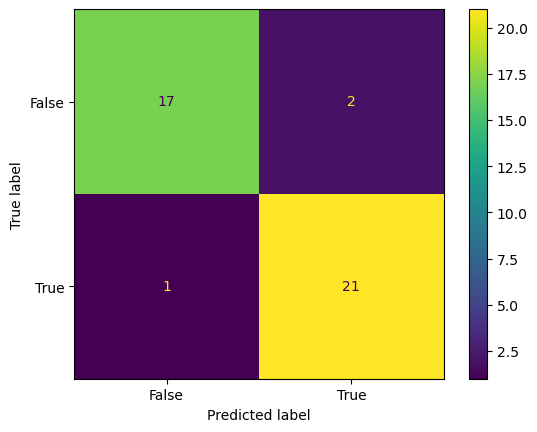

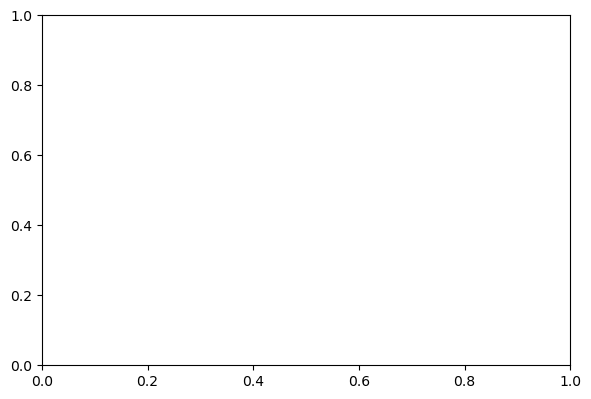

<Figure size 640x480 with 0 Axes>

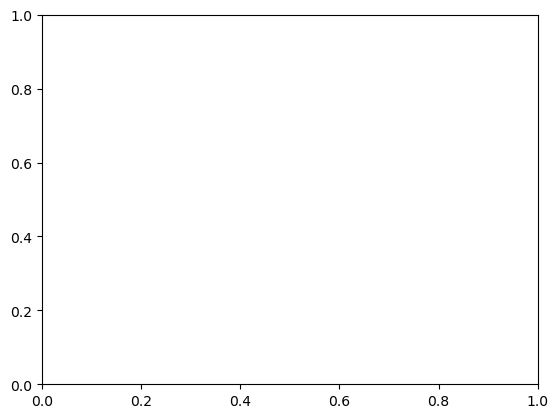

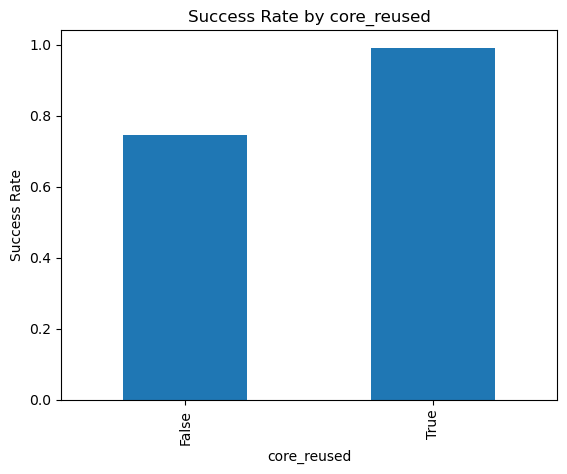

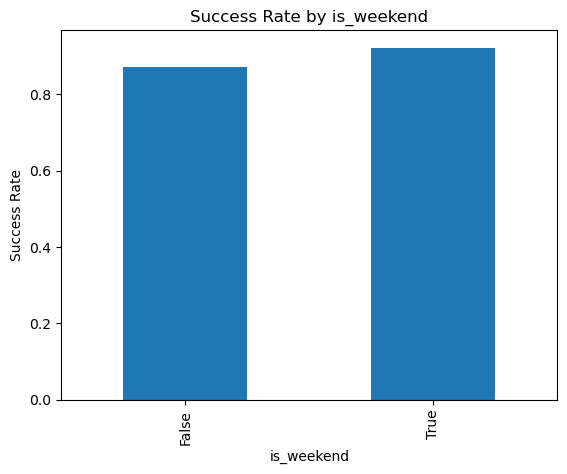

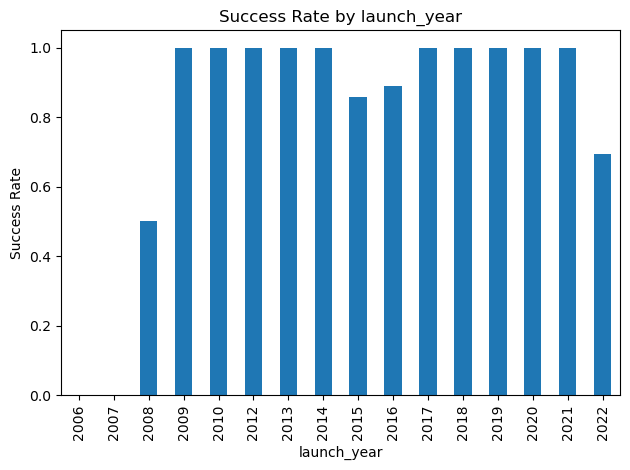

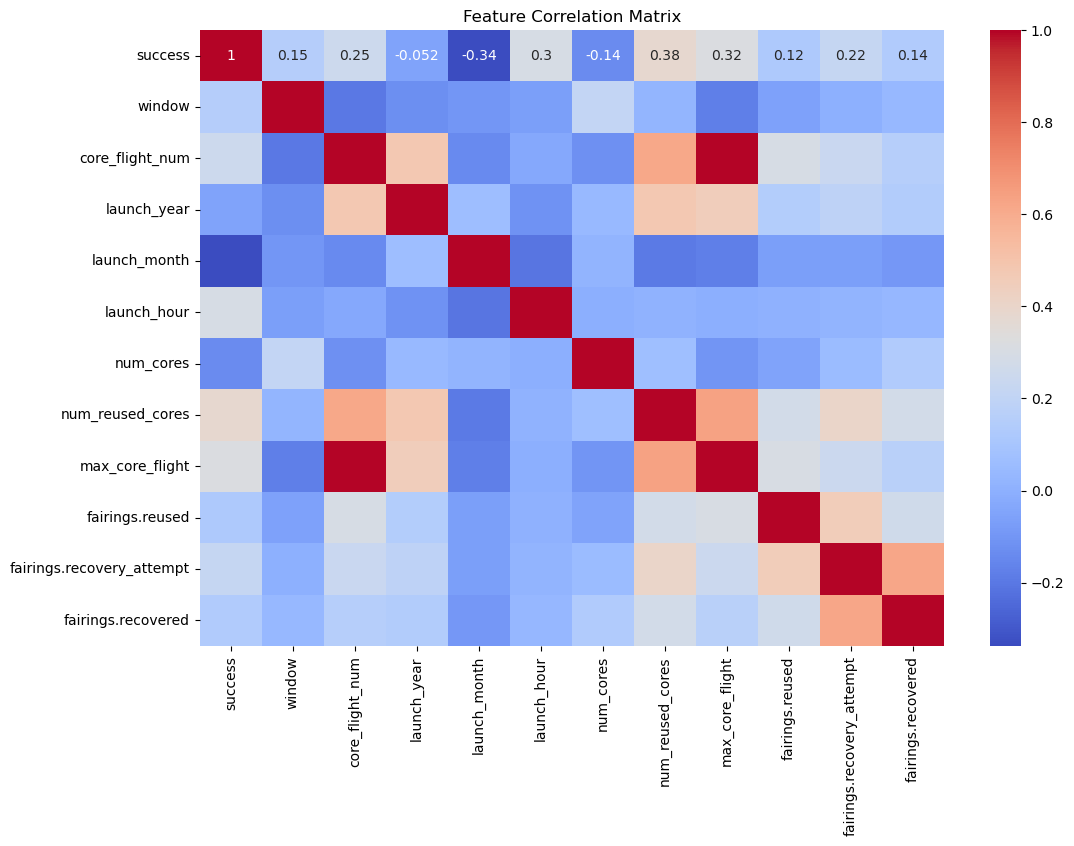

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns

# Categorical columns you want to analyze
categorical_cols = ['core_reused', 'is_weekend', 'launch_year']

# Plot bar charts of success rate by each categorical column
for col in categorical_cols:
    fig, ax = plt.subplots()
    df.groupby(col)['success'].mean().plot(kind='bar', ax=ax)
    ax.set_title(f"Success Rate by {col}")
    ax.set_ylabel("Success Rate")
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12, 8))

# Selecting only numerical + target features
corr_features = ['success', 'window', 'core_flight_num', 'launch_year', 
                 'launch_month', 'launch_hour', 'num_cores', 
                 'num_reused_cores', 'max_core_flight', 
                 'fairings.reused', 'fairings.recovery_attempt', 'fairings.recovered']

sns.heatmap(df[corr_features].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


C:\Users\Jhanzaib\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Jhanzaib\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


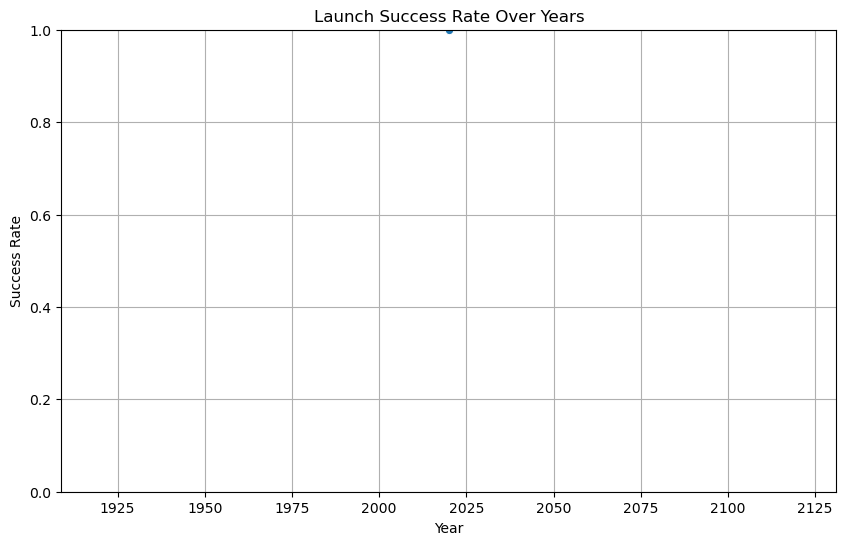

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

df['launch_year'] = pd.to_datetime(df['date_utc']).dt.year
success_rate_by_year = df.groupby('launch_year')['success'].mean()

plt.figure(figsize=(10,6))
sns.lineplot(x=success_rate_by_year.index, y=success_rate_by_year.values, marker='o')
plt.title('Launch Success Rate Over Years')
plt.xlabel('Year')
plt.ylabel('Success Rate')
plt.ylim(0,1)
plt.grid(True)
plt.show()


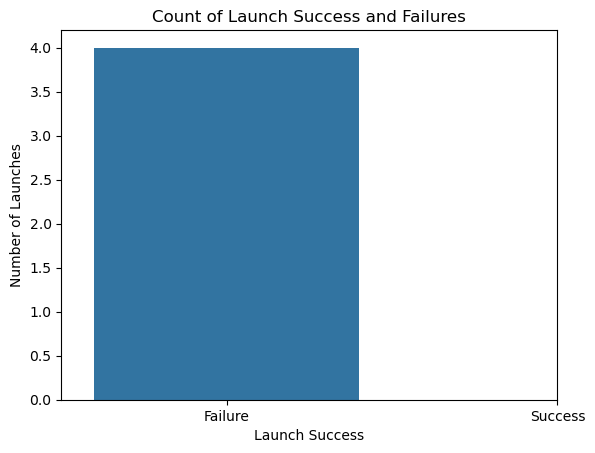

In [134]:
sns.countplot(data=df, x='success')
plt.title('Count of Launch Success and Failures')
plt.xlabel('Launch Success')
plt.ylabel('Number of Launches')
plt.xticks([0,1], ['Failure', 'Success'])
plt.show()


C:\Users\Jhanzaib\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


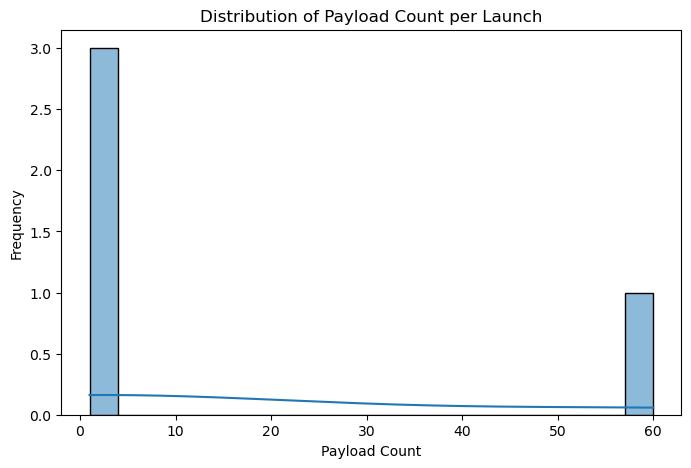

In [136]:
plt.figure(figsize=(8,5))
sns.histplot(df['payload_count'], bins=20, kde=True)
plt.title('Distribution of Payload Count per Launch')
plt.xlabel('Payload Count')
plt.ylabel('Frequency')
plt.show()


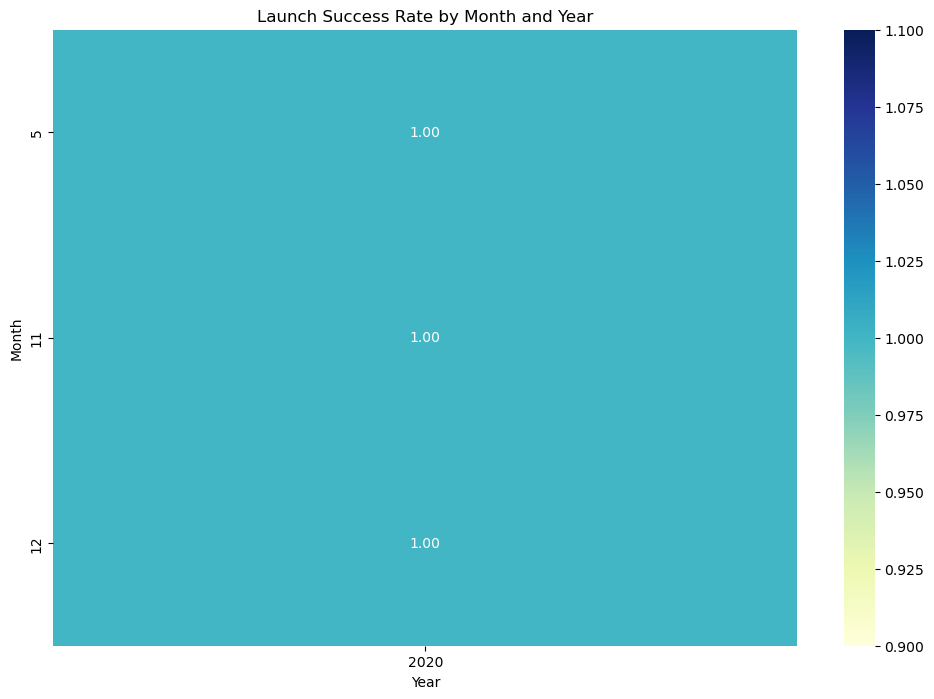

In [135]:
df['launch_month'] = pd.to_datetime(df['date_utc']).dt.month
pivot = df.pivot_table(index='launch_month', columns='launch_year', values='success', aggfunc='mean')

plt.figure(figsize=(12,8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Launch Success Rate by Month and Year')
plt.ylabel('Month')
plt.xlabel('Year')
plt.show()


In [132]:
import pandas as pd
import folium
from folium.plugins import MarkerCluster

# Sample data: replace with your actual df
data = {
    'name': ['Starlink 1', 'GPS III SV04', 'CRS-21', 'Demo-2'],
    'date_utc': ['2020-11-24T15:13:00Z', '2020-11-05T23:24:00Z', '2020-12-06T16:17:00Z', '2020-05-30T19:22:00Z'],
    'success': [True, True, True, True],
    'core_reused': [True, False, True, False],
    'payload_count': [60, 1, 2, 2],
    'launch_site': ['Cape Canaveral', 'Cape Canaveral', 'Kennedy Space Center', 'Kennedy Space Center']
}
df = pd.DataFrame(data)

# Launch site coordinates lookup
launch_sites = {
    'Cape Canaveral': [28.3922, -80.6077],
    'Kennedy Space Center': [28.5721, -80.6480],
    'Vandenberg': [34.7420, -120.5724]
}

# Map launch site to lat/lon
df['latitude'] = df['launch_site'].map(lambda x: launch_sites.get(x, [None, None])[0])
df['longitude'] = df['launch_site'].map(lambda x: launch_sites.get(x, [None, None])[1])

# Create base map centered on Florida
launch_map = folium.Map(
    location=[28.5618571, -80.577366],
    zoom_start=5,
    tiles='cartodbpositron'
)

# Add marker clustering
marker_cluster = MarkerCluster().add_to(launch_map)

# Icon colors and icons based on success
icon_colors = {
    True: {'color': 'green', 'icon': 'check'},
    False: {'color': 'red', 'icon': 'times'}
}

# Add markers
for idx, row in df.iterrows():
    popup_html = f"""
    <b>{row['name']}</b><br>
    <b>Date:</b> {pd.to_datetime(row['date_utc']).strftime('%Y-%m-%d')}<br>
    <b>Status:</b> {'✅ Success' if row['success'] else '❌ Failure'}<br>
    <b>Rocket:</b> {'♻️ Reused Core' if row['core_reused'] else '🆕 New Core'}<br>
    <b>Payload Count:</b> {row['payload_count']}<br>
    <b>Launch Site:</b> {row['launch_site']}
    """

    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_html, max_width=300),
        icon=folium.Icon(
            color=icon_colors[row['success']]['color'],
            icon=icon_colors[row['success']]['icon'],
            prefix='fa'
        )
    ).add_to(marker_cluster)

# Add map title
title_html = '''
    <h3 align="center" style="font-size:16px">
    <b>SpaceX Launch History</b><br>
    <span style="color:green">✓ Success</span> | 
    <span style="color:red">✗ Failure</span>
    </h3>
'''
launch_map.get_root().html.add_child(folium.Element(title_html))

# Show map
launch_map
